In [1]:
import uproot  # For reading ROOT files efficiently

import awkward as ak  # To represent nested data in columnar format
import numpy as np  # For numerical calculations such as histogramming

import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator  # For adding minor ticks to plot axes

import requests  # For making HTTP requests

import time  # For timing operations and adding delays if needed

In [2]:
# Integrated luminosity in inverse femtobarns
lumi = 10000.

# Fraction of events to process (1 means all events)
fraction = 1

# Conversion factor from MeV to GeV
MeV2GeV = 0.001

# Initial weight factor
weight = 1.

# Minimum transverse momentum (pT) limit in GeV
pt_lim = 30

# MV2c10 b-tagging algorithm discriminant cut value
MV2c10_lim = 0.828

# Dictionary of samples to be processed
samples = {
    # Real data samples
    'data': {'list' : ['data_A','data_B','data_C','data_D'],},
    
    # Main Monte Carlo (MC) sample: top quark pair production
    'MC' : {  'list' : ['mc_410000.ttbar_lep'],},
    
    # Single top quark production samples
    'Single top' : {  'list' : [
        'mc_410011.single_top_tchan',      # t-channel single top
        'mc_410012.single_antitop_tchan',  # t-channel single anti-top
        'mc_410013.single_top_wtchan',     # Wt-channel single top
        'mc_410014.single_antitop_wtchan', # Wt-channel single anti-top
        'mc_410025.single_top_schan',      # s-channel single top
        'mc_410026.single_antitop_schan'   # s-channel single anti-top
        ],},
    
    # Diboson production samples
    'Diboson' : {  'list' : [
        'mc_363356.ZqqZll',    # Z(qq)Z(ll)
        'mc_363358.WqqZll',    # W(qq)Z(ll)
        'mc_363359.WpqqWmlv',  # W+(qq)W-(lv)
        'mc_363360.WplvWmqq',  # W+(lv)W-(qq)
        'mc_363359.WpqqWmlv',  # W+(qq)W-(lv)
        'mc_363360.WplvWmqq',  # W+(lv)W-(qq)
        'mc_363489.WlvZqq'     # W(lv)Z(qq)
         ],},
        }

In [81]:
def calc_weight(data):
    # Calculate the common scale factor
    scale = (data["scaleFactor_LepTRIGGER"] * data["scaleFactor_PILEUP"] * data["scaleFactor_BTAG"] *
             (data["mcWeight"] / data["SumWeights"]) * (data["XSection"] * lumi))

    # Calculate the scaleFactorE and scaleFactorM
    scaleFactorE = data["scaleFactor_ELE"] * scale
    scaleFactorM = data["scaleFactor_MUON"] * scale

    # Create boolean masks based on conditions
    e_condition = data["trigE"] & (data["mcWeight"] != 0.0)

    # Use boolean masks to select relevant entries from scaleFactorE and scaleFactorM
    weight_list = ak.where(e_condition, scaleFactorE, scaleFactorM)

    return weight_list

def cut_trig(trigE, trigM):
    # Return True if either electron or muon trigger fired
    return trigE | trigM

def one_lep(lep_n):
    # Return True if exactly one lepton in the event
    return lep_n == 1

def cut_lep_pt(lep_pt):
    # Return True if lepton pT is above 30 GeV
    return lep_pt * MeV2GeV >= pt_lim

def cut_met_et(met_et):
    # Return True if missing ET is above 30 GeV
    return met_et * MeV2GeV >= 30

def cut_W_mt(lep_pt, lep_phi, met_et, met_phi):
    # Calculate W transverse mass and apply cut
    Wmt_2 = 2 * lep_pt * met_et * (1 - np.cos(lep_phi - met_phi)) * MeV2GeV**2
    Wmt = ak.where(Wmt_2 >= 0, np.sqrt(Wmt_2), np.NaN)
    bool_list = Wmt >= 30
    return [Wmt, bool_list]

def cut_Njet_and_Nbjet(jet_pt, jet_MV2c10):
    # Convert jet pT to GeV
    jet_pt_GeV = jet_pt * MeV2GeV

    # Count jets above pT threshold
    num_pt = ak.sum(jet_pt_GeV >= pt_lim, axis=1)

    # Count b-tagged jets
    num_btag = ak.sum(jet_MV2c10 >= MV2c10_lim, axis=1)

    # Require at least 4 jets and 2 b-tagged jets
    bool_list = (num_pt >= 4) & (num_btag >= 2)

    # Get pT of leading jet, if it exists
    leading_pt_jets = ak.where(
        bool_list & (ak.num(jet_pt_GeV) > 0),
        ak.firsts(jet_pt_GeV, axis=1),
        np.nan)

    # Store number of jets and b-jets for events passing the cut
    num_jets = ak.where(bool_list, num_pt, np.nan)
    b_jets = ak.where(bool_list, num_btag, np.nan)

    return [bool_list, num_jets, b_jets, leading_pt_jets]

def mtop(jet_pt, jet_E, jet_eta, jet_phi, jet_MV2c10, lep_pt, lep_eta, lep_phi, lep_E, met_et, met_phi):
    # This function calculates the mass of semileptonic decaying top quark and hadronic decay top quark 

    # Convert lepton kinematics to GeV
    lep_E_GeV = lep_E * 1e-3
    lep_pt_mag = lep_pt * 1e-3
    lep_px = lep_pt_mag * np.cos(lep_phi)
    lep_py = lep_pt_mag * np.sin(lep_phi)
    lep_pz = lep_pt_mag / np.tan(2.0 * np.arctan( np.exp( -lep_eta ) ) )

    # Convert MET to GeV and calculate its components
    met_pt_mag = met_et * 1e-3
    met_px = met_pt_mag * np.cos(met_phi)
    met_py = met_pt_mag * np.sin(met_phi)

    # Calculate neutrino pz solutions
    # Calculate coefficient 'a' of the quadratic equation
    a = 4 * (lep_E_GeV**2 - lep_pz**2)
    
    # Calculate coefficient 'b' of the quadratic equation, 6464.16 is (80.4 GeV)^2, which is the W boson mass squared
    b = -4 * (6464.16 + ((lep_px + met_px)**2) + ((lep_py + met_py)**2) - (lep_E_GeV**2) - (met_pt_mag**2) + (lep_pz**2)) * lep_pz
    
    # Calculate coefficient 'c' 
    c = 4 * (lep_E_GeV**2) * (met_pt_mag**2) - (6464.16 + ((lep_px + met_px)**2) + ((lep_py + met_py)**2) - (lep_E_GeV**2) - (met_pt_mag**2) + (lep_pz**2))**2
    
    # Calculate the discriminant
    Delta = b**2 - 4 * a * c
    
    # Calculate the two solutions for met_pz using the quadratic formula
    # If Delta is negative, set the solution to NaN
    met_pz1 = ak.where(Delta >= 0, (-b + np.sqrt(Delta)) / ( 2 * a), np.nan)
    met_pz2 = ak.where(Delta >= 0, (-b - np.sqrt(Delta)) / ( 2 * a), np.nan)

    # Calculate the two solutions for met_E
    met_E_1 = np.sqrt(met_px**2 + met_py**2 + met_pz1**2)
    met_E_2 = np.sqrt(met_px**2 + met_py**2 + met_pz2**2)

    # Convert jet kinematics to GeV
    Jet_E = jet_E * 1e-3
    Jet_pt = jet_pt * 1e-3
    px = Jet_pt * np.cos(jet_phi)
    py = Jet_pt * np.sin(jet_phi)
    pz = Jet_pt / np.tan(2.0 * np.arctan(np.exp(-jet_eta)))

    # Identify b-tagged jets
    b_tagged = jet_MV2c10 >= MV2c10_lim

    # Separate b-tagged and non-b-tagged jets
    b_tagged_px, b_tagged_py, b_tagged_pz, b_tagged_E = px[b_tagged], py[b_tagged], pz[b_tagged], Jet_E[b_tagged]
    
    b_tagged_eta, b_tagged_phi = jet_eta[b_tagged], jet_phi[b_tagged]
    
    non_b_px, non_b_py, non_b_pz, non_b_E = px[~b_tagged], py[~b_tagged], pz[~b_tagged], Jet_E[~b_tagged]
    

    # Calculate delta R between lepton and b-tagged jets
    lep_eta_broadcasted, _ = ak.broadcast_arrays(ak.flatten(lep_eta), b_tagged_eta)
    lep_phi_broadcasted, _ = ak.broadcast_arrays(ak.flatten(lep_phi), b_tagged_phi)
    dR = np.sqrt((lep_eta_broadcasted - b_tagged_eta)**2 + (lep_phi_broadcasted - b_tagged_phi)**2)
    
    # Find indices of closest and farthest b-tagged jets to the lepton
    max_dR_indices = ak.singletons(ak.argmax(dR, axis=1))
    min_dR_indices = ak.singletons(ak.argmin(dR, axis=1))

    # Extract kinematics of closest and farthest b-tagged jets
    closest_b_jet_E, closest_b_jet_px = b_tagged_E[min_dR_indices], b_tagged_px[min_dR_indices]
    closest_b_jet_py, closest_b_jet_pz = b_tagged_py[min_dR_indices], b_tagged_pz[min_dR_indices]
    farthest_b_jet_E, farthest_b_jet_px = b_tagged_E[max_dR_indices], b_tagged_px[max_dR_indices]
    farthest_b_jet_py, farthest_b_jet_pz = b_tagged_py[max_dR_indices], b_tagged_pz[max_dR_indices]

    # Helper function to create combinations of jets
    def combo(list1):
        jets_pairs = ak.combinations(list1, 2, fields=['List1', 'List2'])
        sum_List = jets_pairs['List1'] + jets_pairs['List2']
        return sum_List

    # Create combinations of non-b-tagged jets
    com_non_b_px, com_non_b_py = combo(non_b_px), combo(non_b_py)
    com_non_b_pz, com_non_b_E = combo(non_b_pz), combo(non_b_E)

    # Calculate mass difference from W boson mass    
    W_mass_2 = com_non_b_E**2 - (com_non_b_px**2 + com_non_b_py**2 + com_non_b_pz**2)
    W_mass = ak.where(W_mass_2 >0, np.sqrt(W_mass_2), np.NaN)
    com_DM_W = 80.4 - W_mass
    abs_diff = np.abs(com_DM_W)

    # Select jet pairs close to W mass           
    check_abs = abs_diff <= 20
    check_abs_array = ak.singletons(ak.any(check_abs, axis=1))

    # Find best jet pair
    min_diff_indices = ak.argmin(abs_diff, axis=1)
    min_indices = ak.singletons(min_diff_indices)

    # Extract kinematics of selected jet pair
    sel_com_jet_E = com_non_b_E[min_indices]
    sel_com_jet_px, sel_com_jet_py = com_non_b_px[min_indices], com_non_b_py[min_indices]
    sel_com_jet_pz = com_non_b_pz[min_indices]

    # Handle cases where no suitable jet pair is found
    sel_com_jet_E = ak.without_parameters(ak.where(ak.num(sel_com_jet_E, axis=1) == 0, np.nan, sel_com_jet_E))
    sel_com_jet_px = ak.without_parameters(ak.where(ak.num(sel_com_jet_px, axis=1) == 0, np.nan, sel_com_jet_px))
    sel_com_jet_py = ak.without_parameters(ak.where(ak.num(sel_com_jet_py, axis=1) == 0, np.nan, sel_com_jet_py))
    sel_com_jet_pz = ak.without_parameters(ak.where(ak.num(sel_com_jet_pz, axis=1) == 0, np.nan, sel_com_jet_pz))

    # Calculate hadronic top mass
    m_jjj = np.sqrt( (sel_com_jet_E + farthest_b_jet_E)**2 - (sel_com_jet_px + farthest_b_jet_px)**2 -    
                     (sel_com_jet_py + farthest_b_jet_py)**2 - (sel_com_jet_pz + farthest_b_jet_pz)**2 )
    
    # Apply W mass constraint
    m_jjj = ak.where(check_abs_array, m_jjj, np.nan).tolist()

    # Calculate leptonic top mass for both neutrino pz solutions
    m_lvb_1 = (lep_E_GeV + met_E_1 + closest_b_jet_E)**2 - ( (lep_px + met_px + closest_b_jet_px)**2 +
     (lep_py + met_py + closest_b_jet_py)**2 + (lep_pz + met_pz1 + closest_b_jet_pz)**2 )

    m_lvb_2 = (lep_E_GeV + met_E_2 + closest_b_jet_E)**2 - ( (lep_px + met_px + closest_b_jet_px)**2 +
     (lep_py + met_py + closest_b_jet_py)**2 + (lep_pz + met_pz2 + closest_b_jet_pz)**2 )

    # Handle complex masses
    m_lvb_1 = ak.where(m_lvb_1 >= 0, np.sqrt(m_lvb_2), np.nan).tolist()
    m_lvb_2 = ak.where(m_lvb_2 >= 0, np.sqrt(m_lvb_2), np.nan).tolist()

    # Flatten and return results
    m_jjj, m_lvb_1, m_lvb_2 = ak.flatten(m_jjj), ak.flatten(m_lvb_1), ak.flatten(m_lvb_2)
    return [m_jjj, m_lvb_1, m_lvb_2]

def read_file(path,sample,start_entry):
    """
    Reads data from a file, applies cuts, and returns an awkward array.

    Args:
        path (str): Path to the file.
        sample (str): Sample name.
        start_entry (int): Starting entry for data retrieval.

    Returns:
        ak.Array: Concatenated awkward array containing events passing all cuts.
    """
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample

    # Open the tree called "mini" using a context manager (will automatically close files/resources)
    with uproot.open(f"{path}:mini") as tree:
        numevents = tree.num_entries  # Number of events
        for data in tree.iterate(
            [
                "mcWeight", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER",
                "scaleFactor_PILEUP", "scaleFactor_BTAG", "trigE", "trigM", "lep_n", "lep_pt",
                "lep_eta", "lep_phi", "lep_charge", "lep_type", "met_et", "met_phi", "SumWeights",
                "XSection", "jet_pt", "jet_MV2c10", "jet_n", "jet_eta", "jet_phi", "jet_E",
                "lep_type", "lep_E", "eventNumber"
            ],
            library="ak",  # Choose output type as awkward array
            entry_start=int(numevents * fraction * start_entry),
            entry_stop=numevents * fraction * (start_entry + 1)
            ):

            nIn = len(data) # number of events in this batch

            # Check triggerE, triggerM  conditions
            data = data[cut_trig(data.trigE,data.trigM)]

            # Require exactly one lepton
            data = data[one_lep(data.lep_n)]

            # cut on lepton lep_pt
            data = data[ak.flatten(cut_lep_pt(data.lep_pt))]

            # Cut on missing transverse energy met_et
            data = data[cut_met_et(data.met_et)]

            # Cut on W boson transverse mass
            W_mt_data = cut_W_mt(data.lep_pt, data.lep_phi, data.met_et, data.met_phi)

            data['W_mass'] = ak.flatten(W_mt_data[0])

            data = data[ak.flatten(W_mt_data[1])]

            # Check Njet and Nbjet  conditions
            jets_data = cut_Njet_and_Nbjet(data.jet_pt,data.jet_MV2c10)

            data['q_jets'] = jets_data[1]

            data['b_jets'] = jets_data[2]

            data['pt_jets'] = jets_data[3]

            data = data[jets_data[0]]

            if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
                data['total_weight'] = calc_weight(data)

            mtop_data = mtop(data.jet_pt ,data.jet_E ,data.jet_eta ,data.jet_phi ,data.jet_MV2c10 ,data.lep_pt, data.lep_eta ,data.lep_phi, data.lep_E, data.met_et, data.met_phi)

            data['mtop'] = mtop_data[0]

            data['mtop_1'] = mtop_data[1]

            data['mtop_2'] = mtop_data[2]

            nOut = len(data) # number of events passing cuts in this batch
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

    return ak.concatenate(data_all) # return array containing events passing all cuts


def get_data_from_files(start, local):
    """
    Retrieves data from files and returns a dictionary of awkward arrays.

    Args:
        start (int): The starting point for data retrieval.
        local (int): Flag indicating whether to use local files (1) or web URLs (0).

    Returns:  dict: A dictionary containing concatenated awkward arrays for different samples.
    """
    data = {}  # Define an empty dictionary to hold awkward arrays
    MC_weight = []
    BG_MC_weight = []

    for s in samples:  # Loop over samples
        print(f"Processing {s} samples")  # Print which sample is being processed
        frames = []  # Define an empty list to hold data

        for val in samples[s]["list"]:  # Loop over each file
            if local == 1:
                tuple_path, prefix = "", ""
                fileString = f"{tuple_path}{prefix}{val}.1lep.root"  # File name to open
                frames.append(read_file(fileString, val, start))  # Append array returned from read_file
            else:
                tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1lep/"
                if s == "data":
                    prefix = "Data/"
                elif s != "data":
                    prefix = "MC/"

                fileString = f"{tuple_path}{prefix}{val}.1lep.root"  # File name to open
                frames.append(read_file(fileString, val, start))  # Append array returned from read_file

        data[s] = ak.concatenate(frames)  # Dictionary entry is concatenated awkward arrays

    return data  # Return the dictionary of awkward arrays


In [ ]:
# Lists for the main analysis
met_et_list = []       # Missing transverse energy
Nbjet_list = []        # Number of b-jets
Njet_list = []         # Number of jets
MV2c10 = []            # b-tagging discriminant value
pt = []                # Transverse momentum
mW = []                # W boson mass
Weight = []            # Event weight
mtop_list = []         # Top quark mass
mtop2_list = []        # Second top quark mass
mtop3_list = []        # Third top quark mass

# Lists for Monte Carlo (MC) simulated data
met_et_list_MC = []    # Missing transverse energy in MC data
Nbjet_list_MC = []     # Number of b-jets in MC data
Njet_list_MC = []      # Number of jets in MC data
pt_MC = []             # Transverse momentum in MC data
mW_MC = []             # W boson mass in MC data
Weight_MC = []         # Event weight in MC data
mtop_list_MC = []      # Top quark mass in MC data
mtop2_list_MC = []     # Second top quark mass in MC data
mtop3_list_MC = []     # Third top quark mass in MC data

# Lists for dilepton data
met_et_list_Di = []    # Missing transverse energy in dilepton data
Nbjet_list_Di = []     # Number of b-jets in dilepton data
Njet_list_Di = []      # Number of jets in dilepton data
pt_Di = []             # Transverse momentum in dilepton data
mW_Di = []             # W boson mass in dilepton data
Weight_Di = []         # Event weight in dilepton data
mtop_list_Di = []      # Top quark mass in dilepton data
mtop2_list_Di = []     # Second top quark mass in dilepton data
mtop3_list_Di = []     # Third top quark mass in dilepton data

# Lists for single top data
met_et_list_ST = []    # Missing transverse energy in single top data
Nbjet_list_ST = []     # Number of b-jets in single top data
Njet_list_ST = []      # Number of jets in single top data
pt_ST = []             # Transverse momentum in single top data
mW_ST = []             # W boson mass in single top data
Weight_ST = []         # Event weight in single top data
mtop_list_ST = []      # Top quark mass in single top data
mtop2_list_ST = []     # Second top quark mass in single top data
mtop3_list_ST = []     # Third top quark mass in single top data

number_of_runs =  10  # reduce this is if you want the code to run quicker (1 - 10)

local_or_online = 1 # process all files 0 for web, 1 for local

for i in range(number_of_runs):
    fraction = 0.1
    start = time.time()  # Time at the start of the whole processing

    # Get data from files
    list_tem = get_data_from_files(i, local_or_online)
    data = list_tem

    # Process data for "data" sample
    data_type = "data"
    met_et_list.append(data[data_type]['met_et'] * MeV2GeV)
    Njet_list.append(data[data_type]['q_jets'])
    Nbjet_list.append(data[data_type]['b_jets'])
    pt.append(data[data_type]['pt_jets'])
    mW.append(data[data_type]['W_mass'])
    mtop_list.append(data[data_type]['mtop'])
    mtop2_list.append(data[data_type]['mtop_1'])
    mtop3_list.append(data[data_type]['mtop_2'])

    # Process data for "MC" sample
    data_type = "MC"
    Weight_MC.append(data[data_type]['total_weight'])
    met_et_list_MC.append(data[data_type]['met_et'] * MeV2GeV)
    Njet_list_MC.append(data[data_type]['q_jets'])
    Nbjet_list_MC.append(data[data_type]['b_jets'])
    pt_MC.append(data[data_type]['pt_jets'])
    mW_MC.append(data[data_type]['W_mass'])
    mtop_list_MC.append(data[data_type]['mtop'])
    mtop2_list_MC.append(data[data_type]['mtop_1'])
    mtop3_list_MC.append(data[data_type]['mtop_2'])

    # Process data for "Single top" sample
    data_type = "Single top"
    Weight_ST.append(data[data_type]['total_weight'])
    met_et_list_ST.append(data[data_type]['met_et'] * MeV2GeV)
    Njet_list_ST.append(data[data_type]['q_jets'])
    Nbjet_list_ST.append(data[data_type]['b_jets'])
    mW_ST.append(data[data_type]['W_mass'])
    pt_ST.append(data[data_type]['pt_jets'])
    mtop_list_ST.append(data[data_type]['mtop'])
    mtop2_list_ST.append(data[data_type]['mtop_1'])
    mtop3_list_ST.append(data[data_type]['mtop_2'])

    # Process data for "Diboson" sample
    data_type = "Diboson"
    Weight_Di.append(data[data_type]['total_weight'])
    met_et_list_Di.append(data[data_type]['met_et'] * MeV2GeV)
    Njet_list_Di.append(data[data_type]['q_jets'])
    Nbjet_list_Di.append(data[data_type]['b_jets'])
    mW_Di.append(data[data_type]['W_mass'])
    pt_Di.append(data[data_type]['pt_jets'])
    mtop_list_Di.append(data[data_type]['mtop'])
    mtop2_list_Di.append(data[data_type]['mtop_1'])
    mtop3_list_Di.append(data[data_type]['mtop_2'])

    elapsed = time.time() - start # time after whole processing
    print("Time taken: "+str(round(elapsed/60,1))+"min", f"i = {i+1}","\n") # print total time taken to process every file

    del(list_tem)
    del(data)

# Flatten the lists for easier analysis
mtop_list = ak.flatten(mtop_list)
mtop2_list = ak.flatten(mtop2_list)
mtop3_list = ak.flatten(mtop3_list)
met_et_list = ak.flatten(met_et_list)
Njet_list = ak.flatten(Njet_list)
Nbjet_list = ak.flatten(Nbjet_list)
pt = ak.flatten(pt)
mW = ak.flatten(mW)

# Flatten MC-related lists
Weight_MC = ak.flatten(Weight_MC)
mtop_list_MC = ak.flatten(mtop_list_MC)
mtop2_list_MC = ak.flatten(mtop2_list_MC)
mtop3_list_MC = ak.flatten(mtop3_list_MC)
met_et_list_MC = ak.flatten(met_et_list_MC)
Njet_list_MC = ak.flatten(Njet_list_MC)
Nbjet_list_MC = ak.flatten(Nbjet_list_MC)
mW_MC = ak.flatten(mW_MC)
pt_MC = ak.flatten(pt_MC)

# Flatten Single top-related lists
Weight_ST = ak.flatten(Weight_ST)
mtop_list_ST = ak.flatten(mtop_list_ST)
mtop2_list_ST = ak.flatten(mtop2_list_ST)
mtop3_list_ST = ak.flatten(mtop3_list_ST)
met_et_list_ST = ak.flatten(met_et_list_ST)
Njet_list_ST = ak.flatten(Njet_list_ST)
Nbjet_list_ST = ak.flatten(Nbjet_list_ST)
mW_ST = ak.flatten(mW_ST)
pt_ST = ak.flatten(pt_ST)

# Flatten Diboson-related lists
Weight_Di = ak.flatten(Weight_Di)
mtop_list_Di = ak.flatten(mtop_list_Di)
mtop2_list_Di = ak.flatten(mtop2_list_Di)
mtop3_list_Di = ak.flatten(mtop3_list_Di)
met_et_list_Di = ak.flatten(met_et_list_Di)
Njet_list_Di = ak.flatten(Njet_list_Di)
Nbjet_list_Di = ak.flatten(Nbjet_list_Di)
mW_Di = ak.flatten(mW_Di)
pt_Di = ak.flatten(pt_Di)

In [83]:
# Combine mtop2 and mtop3 lists 
mtop2 = ak.flatten([mtop2_list, mtop3_list])
weights_data = ak.Array([1/2] * len(mtop2))

# Combine MC-related lists
mtop2_MC = ak.flatten([mtop2_list_MC, mtop3_list_MC])
weights_MC = ak.flatten([Weight_MC, Weight_MC]) / 2

# Combine Single top-related lists
mtop2_ST = ak.flatten([mtop2_list_ST, mtop3_list_ST])
weights_ST = ak.flatten([Weight_ST, Weight_ST]) / 2

# Combine Diboson-related lists
mtop2_Di = ak.flatten([mtop2_list_Di, mtop3_list_Di])
weights_Di = ak.flatten([Weight_Di, Weight_Di]) / 2

In [84]:
def plot_data(data, data_MC, MC_Weight, data_Di, Di_Weight, data_ST, ST_Weight, 
              x_axis_label, weight_for_data, weight_data):
    """
    Plot histogram data with Monte Carlo simulations and calculate ratio plot.

    Parameters:
    -----------
    data : array
        The main data to be plotted.
    data_MC, data_Di, data_ST : array
        Monte Carlo, Diboson, and Single Top data respectively.
    MC_Weight, Di_Weight, ST_Weight : array-like
        Weights for the respective data sets.
    x_axis_label : str
        Label for the x-axis.
    weight_for_data : bool
        Flags for additional functionality.
    weight_data : array
        Weights for the main data.

    Returns:
    --------
    None
    """

    # Define plot parameters
    xmin, xmax, step_size = 100, 250, 3

    # Define MC data sets and their properties
    datasets = [
        {'data': data_Di, 'weights': Di_Weight, 'color': 'blue', 'label': r'Diboson'},
        {'data': data_ST, 'weights': ST_Weight, 'color': 'cyan', 'label': r'Single top'},
        {'data': data_MC, 'weights': MC_Weight, 'color': 'orange', 'label': r'$t\bar{t}$'}
    ]

    # Create bin edges and centers
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = np.arange(xmin + step_size/2, xmax + step_size/2, step_size)

    # Histogram the data and weights for the data
    if weight_for_data:
        data_x, _ = np.histogram(ak.to_numpy(data), bins=bin_edges, weights=weight_data)
    else:
        data_x, _ = np.histogram(ak.to_numpy(data), bins=bin_edges)

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', label='Data')

    # Plot the Monte Carlo bars
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges,
                                weights=[d['weights'] for d in datasets], stacked=True,
                                color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    mc_x_tot = mc_heights[0]  # Stacked background MC y-axis value

    # Calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack([d['data'] for d in datasets]), bins=bin_edges,
                                    weights=np.hstack([d['weights'] for d in datasets])**2)[0])

    # Plot the statistical uncertainty
    main_axes.bar(bin_centres, 2*mc_x_err, alpha=0.5, bottom=mc_x_tot[2]-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. Unc.')

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)
    
    # Add headspace to the plot
    ymax = max(np.max(data_x), np.max(np.sum(mc_heights[0], axis=0)))
    main_axes.set_ylim(0, ymax * 1.4)  # Add 40% headspace
    
    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel('Events', y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'$\sqrt{s}$=13 TeV, 10 fb$^{-1}$', transform=main_axes.transAxes)
    main_axes.text(0.05, 0.76, r'$t\bar{t} \rightarrow \ell v b\bar{b} q\bar{q}$', transform=main_axes.transAxes)

    main_axes.legend(frameon=False)

    # Calculate and plot residuals
    ratio = data_x / np.sum(mc_heights[0], axis=0)
    residual_axes.errorbar(bin_centres, ratio, fmt='k.')
    residual_axes.axhline(1, color='r', linestyle='--')
    residual_axes.set_xlabel(x_axis_label, fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()

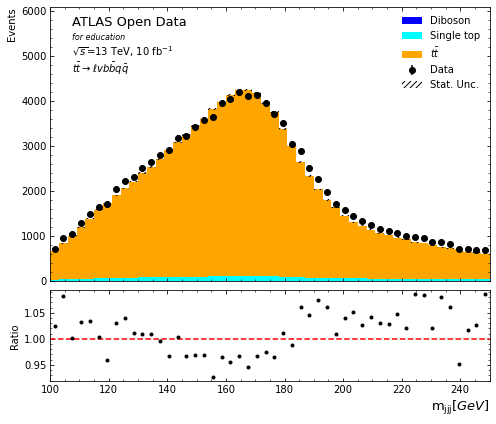

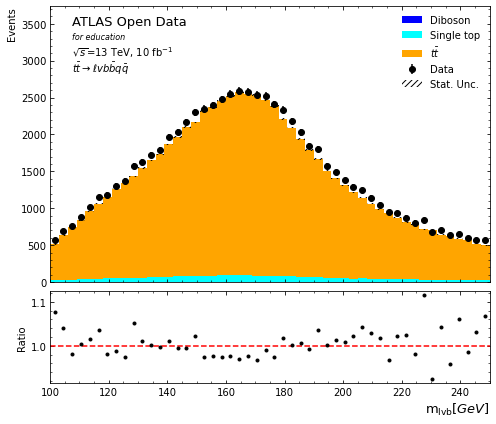

In [85]:
# Plot the trijet mass distribution (m_jjj)
plot_data(mtop_list,        # Main data: list of trijet masses
          mtop_list_MC,     # Monte Carlo data for ttbar
          Weight_MC,        # Weights for Monte Carlo data
          mtop_list_Di,     # Diboson background data
          Weight_Di,        # Weights for Diboson data
          mtop_list_ST,     # Single Top background data
          Weight_ST,        # Weights for Single Top data
          r"$\mathrm{m_{jjj}} [GeV]$",  # x-axis label: trijet mass in GeV
          False,            # Don't use weights for the main data
          [])               # Empty list for data weights (not used)

# Plot the lepton-neutrino-b-jet mass distribution (m_lvb)
plot_data(mtop2,            # Main data: list of lepton-neutrino-b-jet masses
          mtop2_MC,         # Monte Carlo data for ttbar
          weights_MC,       # Weights for Monte Carlo data
          mtop2_Di,         # Diboson background data
          weights_Di,       # Weights for Diboson data
          mtop2_ST,         # Single Top background data
          weights_ST,       # Weights for Single Top data
          r"$\mathrm{m_{lvb}} [GeV]$",  # x-axis label: lepton-neutrino-b-jet mass in GeV
          True,             # Use weights for the main data
          weights_data)     # Weights for the main data